# Решающие деревья

#  I. Немного решающих деревьев
##### Задача 1. Построение "среднего" алгоритма
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [160]:
from matplotlib import pyplot as plt
import sklearn.metrics
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
%matplotlib inline

In [140]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1. (2 балла)__
1. Сгенерируйте выборку $x$ из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных $y$ как сумму $f(x)$ и случайного шума, сгенерированного из равномерного распределения на отрезке $[-1, 1]$ (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: $f(x)$ и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [141]:
X = np.array(np.random.exponential(size=sample_size))
Y = np.array([f(i) for i in X + np.random.uniform(low=-1, high=1)])
# Y_real = np.array([f(i) for i in X])
# print(Y, Y_real)
X = np.reshape(X, (-1, 1))
Y = np.reshape(Y, (-1, 1))

C:\Users\a9282\AppData\Local\Temp\ipykernel_16332\1134854714.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


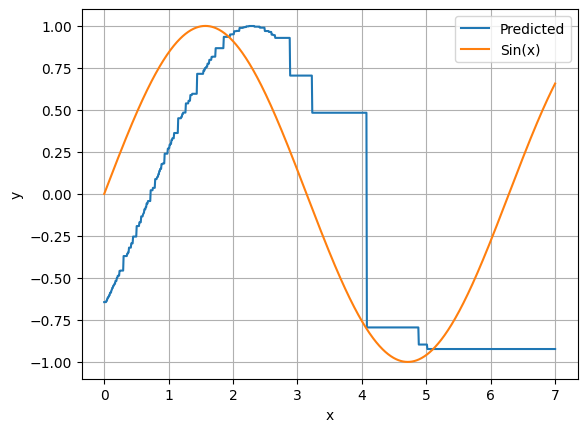

In [142]:
regressor = DecisionTreeRegressor()
regressor.fit(X, Y)

predict_y = []
real_y = []
for i in linspace:
    predict_y.append(regressor.predict([[i]])[0])
    real_y.append(f(i))


fig, ax = plt.subplots()

ax.plot(linspace, predict_y,label='Predicted')
ax.plot(linspace, real_y, label='Sin(x)')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.grid(True)
ax.legend()

fig.show()



__2. (1 балл)__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

In [143]:
def depth(a = None):
    regressors = []
    for _ in range(samples_num):
        X = np.array(np.random.exponential(size=sample_size))
        Y = np.array([f(i) for i in X + np.random.uniform(low=-1, high=1)])

        X = np.reshape(X, (-1, 1))
        Y = np.reshape(Y, (-1, 1))
        regressor = DecisionTreeRegressor(max_depth=a)
        regressor.fit(X, Y)

        predict_y = []
        for i in linspace:
            predict_y.append(regressor.predict([[i]])[0])
        regressors.append(regressor)
        plt.plot(linspace, predict_y, color='gray', alpha=0.5)

    real_y = []
    avg_y = []
    for i in linspace:
        real_y.append(f(i))
        avg_y.append(0)
        for tree in regressors:
            avg_y[-1] += tree.predict([[i]])[0] / samples_num

    plt.plot(linspace, real_y, color='red')
    plt.plot(linspace, avg_y, color='black')
    plt.xlabel('x')
    plt.ylabel('y')

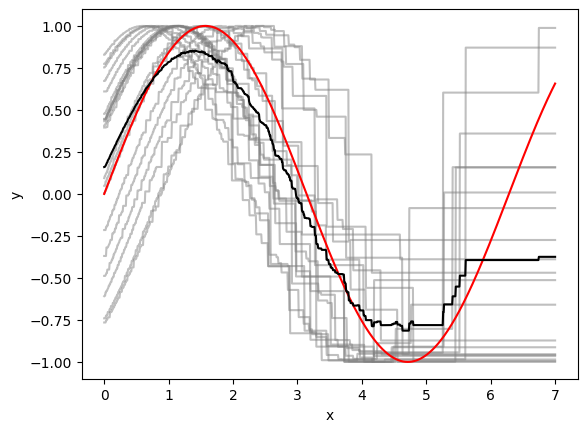

In [144]:
depth(None)

__3.(0.5 балл):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

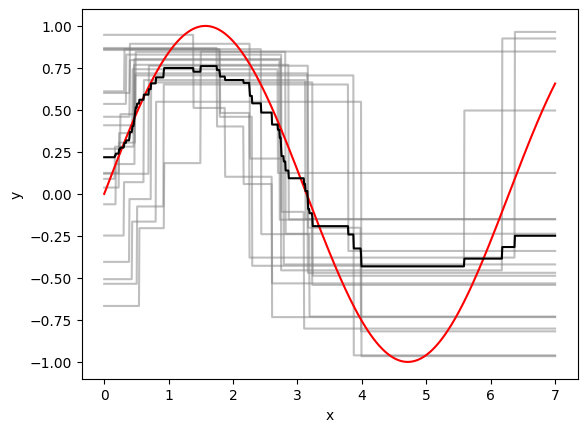

In [145]:
depth(2)


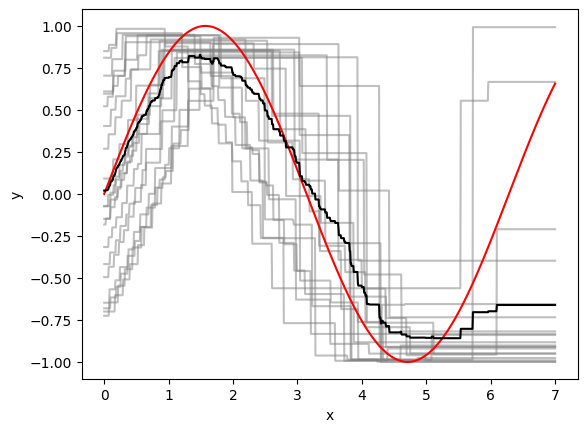

In [146]:
depth(4)

__4. (0.5 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

**Ответ:**

Глубина 2 делает недостаточную аппроксимацию из-за слишком маленького количества возможных итоговых листьев, неограниченная глубина же слишком хорошо аппроксимирует нашу зависимость, но так как эта зависимость довольно шумливая, то по итогу с усреднением мы не получаем достаточно хорошей картины, так как мы пытались описывать какую-то кривую, отличную от sin(x), а не сам sin(x), при глубине 4 мы как раз получаем достаточно хорошую аппроксимацию к кривой, но недостаточно точную, чтобы ориентироваться на шум, что позволяет после усреднения получить наиболее синусообразную функцию

### II. Решающие деревья чужими руками

#### Задача 3.
В этой части вам нужно посмотреть на класс написанный за вас для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__8. (1 балл)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [147]:
import pandas as pd
data = pd.read_csv('students.csv')
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [148]:
from importlib import reload
from matplotlib import pyplot as plt
import hw3code
reload(hw3code)

<module 'hw3code' from 'c:\\Users\\a9282\\Documents\\task7_dstree_practice\\task7_dstree_practice\\hw3code.py'>

Text(0, 0.5, 'Class')

<Figure size 640x480 with 0 Axes>

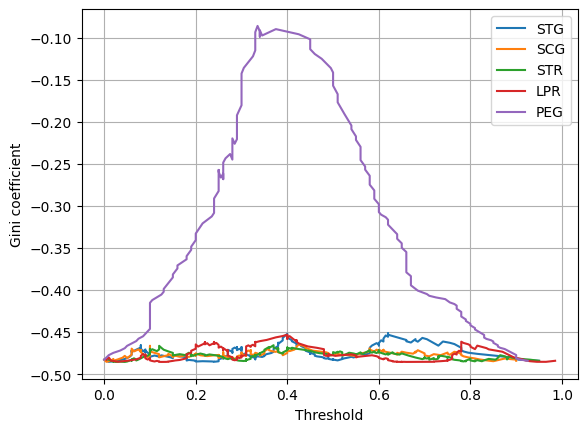

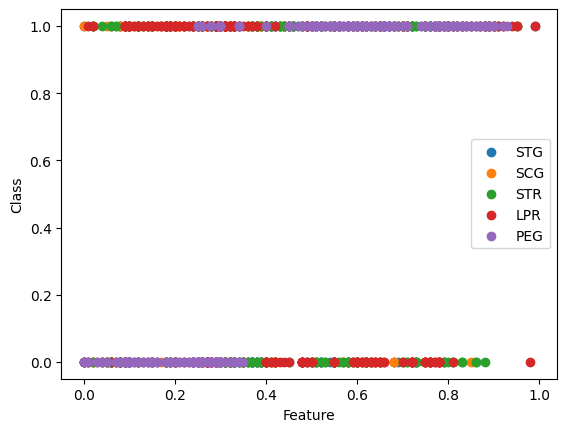

In [149]:
plt.figure()
target = np.copy(data['UNS'])
fig, ax = plt.subplots()
figsc, axsc = plt.subplots()
for feature in data.columns:
    if feature == 'UNS':
        continue
    x, y, bx, by = hw3code.find_best_split(data[feature], target)
    ax.plot(x, y, label=str(feature))
    axsc.scatter(data[feature], target, label=str(feature))



ax.legend()
ax.grid(True)
ax.set_xlabel('Threshold')
ax.set_ylabel('Gini coefficient')
axsc.legend()
axsc.set_xlabel('Feature')
axsc.set_ylabel('Class')





__9. (1 балл)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**
Так как у всех признаков кроме PEG коэффицент Джини большой и равен примерно 0.5 независимо от порога, то по данным, кроме PEG трудно проследить какую-либо зависимость из-за большого неравенства(о чем и говорит коэффицент Джини).
Далее на графике из точек мы видим как хорошо PEG классифицирует данные, где до 0.4 PEG почти все относятся к классу 0, а после к классу 1.
Хорошими для анализа являются графики, где Коэффицент Джини мал и где есть четкая граница, до чего имеется один признак, а после чего другой(что мы видим на графике с точками).

__10. (1 балл)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [150]:
data = pd.read_csv('agaricus-lepiota.data', header=None)
le = sklearn.preprocessing.LabelEncoder()
# print(data)
for col in data.columns:
    data[col] = le.fit_transform(data[col])
# print(data)
X = data.copy()
del X[0]
Y = data[0]
print(X)
print(Y)

      1   2   3   4   5   6   7   8   9   10  ...  13  14  15  16  17  18  19  \
0      5   2   4   1   6   1   0   1   4   0  ...   2   7   7   0   2   1   4   
1      5   2   9   1   0   1   0   0   4   0  ...   2   7   7   0   2   1   4   
2      0   2   8   1   3   1   0   0   5   0  ...   2   7   7   0   2   1   4   
3      5   3   8   1   6   1   0   1   5   0  ...   2   7   7   0   2   1   4   
4      5   2   3   0   5   1   1   0   4   1  ...   2   7   7   0   2   1   0   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
8119   3   2   4   0   5   0   0   0  11   0  ...   2   5   5   0   1   1   4   
8120   5   2   4   0   5   0   0   0  11   0  ...   2   5   5   0   0   1   4   
8121   2   2   4   0   5   0   0   0   5   0  ...   2   5   5   0   1   1   4   
8122   3   3   4   0   8   1   0   1   0   1  ...   1   7   7   0   2   1   0   
8123   5   2   4   0   5   0   0   0  11   0  ...   2   5   5   0   1   1   4   

      20  21  22  
0      2

In [151]:
x_train, x_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.5)
regressor = DecisionTreeRegressor()
regressor.fit(x_train, y_train)
print('Accuracy with regressor:',accuracy_score(y_test, [round(i) for i in(regressor.predict(x_test))]))
classifier = DecisionTreeClassifier()
classifier.fit(x_train, y_train)
print('Accuracy with classifier:',accuracy_score(y_test, classifier.predict(x_test)))

Accuracy with regressor: 1.0
Accuracy with classifier: 1.0


### IIII. Композиции деревьев
#### Задача 4. Сравнение композиционных методов над решающими деревьями
__11. (1 балл)__

Загрузите датасет из соревнования [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/leaderboard). Возьмите из него первые 10к объектов, оставьте только вещественные признаки, а пропуски замените нулями. Разбейте выборку на обучение и контроль в соотношении 7:3.

1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов на обучающей выборке:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом (если это не так, то посмотрите как ведут себя алгоритмы с разными сидами в кроссвалидации и самих алгоритмах). Этот пример демонстрирует, что RandomForest — это более сложный алгоритм, чем бэггинг.

In [153]:
data = pd.read_csv('train.csv')
data = data.iloc[0:10000]
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
data = data.drop(columns=categorical_cols)
data = data.fillna(0)

In [154]:
Y = data['target']
X = data.copy()
del X['target']
del X['ID']
x_train, x_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.3)


In [159]:
# Кросс валидацию выполнил по старинке
treeClassifier = DecisionTreeClassifier()
treeClassifier.fit(x_train, y_train)
print('Accuracy with tree classifier:',accuracy_score(y_test, treeClassifier.predict(x_test)))
baggingClassifier = BaggingClassifier(n_estimators=100)
baggingClassifier.fit(x_train, y_train)
print('Accuracy with bagging classifier:',accuracy_score(y_test, baggingClassifier.predict(x_test)))
randomForestClassifier = RandomForestClassifier(n_estimators=100)
randomForestClassifier.fit(x_train, y_train)
print('Accuracy with random forest classifier:',accuracy_score(y_test, randomForestClassifier.predict(x_test)))


Accuracy with tree classifier: 0.665
Accuracy with bagging classifier: 0.7423333333333333
Accuracy with random forest classifier: 0.741


In [161]:
# Кросс валидация как написано в задании
print("Accuracy with tree classifier", cross_val_score(DecisionTreeClassifier(), X, Y, cv=3))
print("Accuracy with bagging classifier", cross_val_score(BaggingClassifier(n_estimators=100), X, Y, cv=3))
print("Accuracy with random forest classifier", cross_val_score(RandomForestClassifier(n_estimators=100), X, Y, cv=3))

Accuracy with tree classifier [0.66076785 0.67086709 0.67776778]
Accuracy with bagging classifier [0.75794841 0.75187519 0.75127513]
Accuracy with random forest classifier [0.75524895 0.75367537 0.75667567]


#### Задача 5. Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__12. (1 балл)__

Переберите значения от 20 до 1000-5000 деревьев с шагом 20, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $20 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [164]:
randomForestClassifier = RandomForestClassifier(warm_start=True, n_jobs=-1)
accuracies = []
n_trees = []
for n_estimator in range(20, 5001, 20):
    randomForestClassifier.set_params(n_estimators=n_estimator)
    randomForestClassifier.fit(x_train, y_train)
    accuracies.append(accuracy_score(y_test, randomForestClassifier.predict(x_test)))
    n_trees.append(n_estimator)

Text(0, 0.5, 'Accuracy')

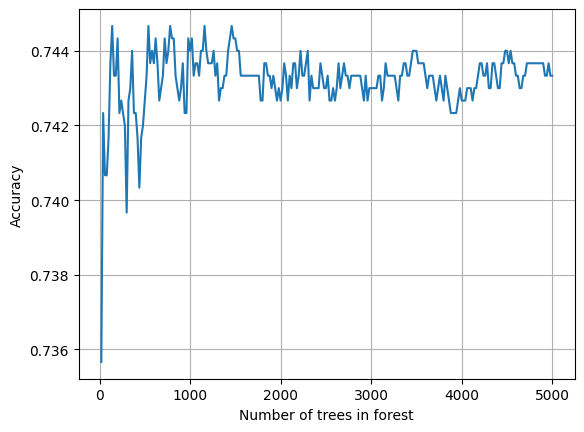

In [167]:
plt.plot(n_trees, accuracies)
plt.grid(True)
plt.xlabel("Number of trees in forest")
plt.ylabel("Accuracy")

__Переобучается ли лес?__ 

Как мы видим на графике лес не подвержен переобучению, что и логично, так как он состоит из большого количества деревьев результат которых усредняется, а каждое отдельное дерево не обучается настолько глубоко, чтобы переобучиться